## CoT Mid-Year Report

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as scs

import sklearn as sk
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

import statsmodels as smm
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

import pygam
from pygam import LinearGAM
from pygam import s,l,f,te

import warnings
import time
warnings.filterwarnings("ignore")



In [20]:
data = pd.read_csv('train_weekly.csv')
test_data = pd.read_csv('test_weekly.csv')
data.Time = pd.to_datetime(data.Time)
test_data.Time = pd.to_datetime(test_data.Time)
# data = data.iloc[::-1].reset_index(drop = True)
# test_data = test_data.iloc[::-1].reset_index(drop = True)

__Predictor Distributions__

In [21]:
data.drop(['Unnamed: 0'], axis = 1, inplace=True)
test_data.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [22]:
lag = ['AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S', 'AM_L', 'AM_S',
       'Lev_L', 'Lev_S','Lev_NetPos']

data[lag] = data[lag].shift(1)
test_data[lag] = test_data[lag].shift(1)

In [23]:
data.drop(['Signal', 'Flag'], axis = 1, inplace = True)
test_data.drop(['Signal', 'Flag'], axis = 1, inplace = True)

data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [57]:
data['dNetPos'] = data['AM_NetPos'].diff()
test_data['dNetPos'] = test_data['AM_NetPos'].diff()
data['dNetPos_log_rate'] = np.log(data['AM_NetPos']).diff() 
test_data['dNetPos_log_rate'] = np.log(test_data['AM_NetPos']).diff()

In [58]:
data = data.dropna().reset_index(drop = True)
test_data = test_data.dropna().reset_index(drop = True)

In [59]:
p = len(data.columns)
p

40

In [60]:
# For training purpose
time_periods = data['Time']
X_train = data.iloc[:,2:p-2]
y_train = data.iloc[:,-2]
y_train_gr = data.iloc[:,-1]
#y_train_alter = weekly_data.iloc[:,2]
X_test = test_data.iloc[:,2:p-2]
y_test = test_data.iloc[:,-2]
y_test_gr = test_data.iloc[:,-1]
#y_test_alter = test_weekly_data.iloc[:,2]

In [61]:
data['year'] = pd.DatetimeIndex(data['Time']).year

In [62]:
data.columns

Index(['Time', 'AM_NetPos', 'FedFunds', '1Y OIS', 'Libor 3 mo', 'Libor 6 mo',
       'Libor 1Y', 'T10Y3M', 'T10Y2Y', 'T10YIE', 'JNK_Price', 'SPX',
       'WILL5000INDFC', 'NASDAQCOM', 'GOLD_price', 'VIX', 'VXVCLS', 'GVZCLS',
       'JPY', 'EUR', 'USDX_Close', 'DTWEXBGS', 'FF_Mkt', 'FF_SMB', 'FF_HML',
       'FF_MOM', 'Lev_NetPos', 'AM_n_L', 'AM_n_S', 'Lev_n_L', 'Lev_n_S',
       'AM_L', 'AM_S', 'Lev_L', 'Lev_S', 'SPY Flows', 'IVV', 'JNK_Volume',
       'dNetPos', 'dNetPos_log_rate', 'year'],
      dtype='object')

__Standardization__

In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["features"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values,i) for i in range(len(X_train.columns))]
print(vif_data)

         features          VIF
0        FedFunds   201.679154
1          1Y OIS   335.779653
2      Libor 3 mo  2228.773320
3      Libor 6 mo  7393.448711
4        Libor 1Y  5055.523613
5          T10Y3M   767.785217
6          T10Y2Y   796.522654
7          T10YIE   293.932010
8       JNK_Price     3.118111
9             SPX   148.891891
10  WILL5000INDFC   174.556821
11      NASDAQCOM    14.905070
12     GOLD_price     1.337800
13            VIX   472.315171
14         VXVCLS   896.386369
15         GVZCLS    58.332885
16            JPY     2.606935
17            EUR    21.416441
18     USDX_Close    32.976537
19       DTWEXBGS     6.527269
20         FF_Mkt     1.497043
21         FF_SMB     1.617841
22         FF_HML     1.409188
23         FF_MOM     1.332738
24     Lev_NetPos          inf
25         AM_n_L   424.553636
26         AM_n_S   172.591684
27        Lev_n_L   175.458110
28        Lev_n_S   213.700799
29           AM_L   244.585827
30           AM_S   227.964771
31      

In [42]:
vif_data2 = pd.DataFrame()
lasso_X_train = X_train[vars]
vif_data2["features"] = lasso_X_train.columns

vif_data2["VIF"] = [variance_inflation_factor(lasso_X_train.values,i) for i in range(len(lasso_X_train.columns))]
print(vif_data2)

       features         VIF
0      FedFunds    4.538381
1        T10Y3M   34.008404
2        T10YIE  129.247911
3     JNK_Price    2.737426
4           SPX    3.462818
5    GOLD_price    1.294197
6           VIX   29.021824
7        GVZCLS   49.570092
8           JPY    1.634667
9           EUR    2.857247
10     DTWEXBGS    4.781181
11       FF_Mkt    1.444632
12       FF_SMB    1.294997
13       FF_HML    1.340925
14       FF_MOM    1.308961
15    SPY Flows    1.300306
16   JNK_Volume    7.795158
17  lag_Lev_n_L   75.537795
18  lag_Lev_n_S   52.436396
19     lag_AM_L  124.266581
20     lag_AM_S   49.058447
21    lag_Lev_L   62.288562


In [67]:
benchmark_res = pd.DataFrame(index = ['Random Forest'], columns = ['MSE', 'MAE'])

__Random Forest__

In [68]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train_std, y_train)

benchmark_res.loc['Random Forest', 'MSE'] = mean_squared_error(y_test, rf.predict(X_test_std))
benchmark_res.loc['Random Forest', 'MAE'] = mean_absolute_error(y_test, rf.predict(X_test_std))

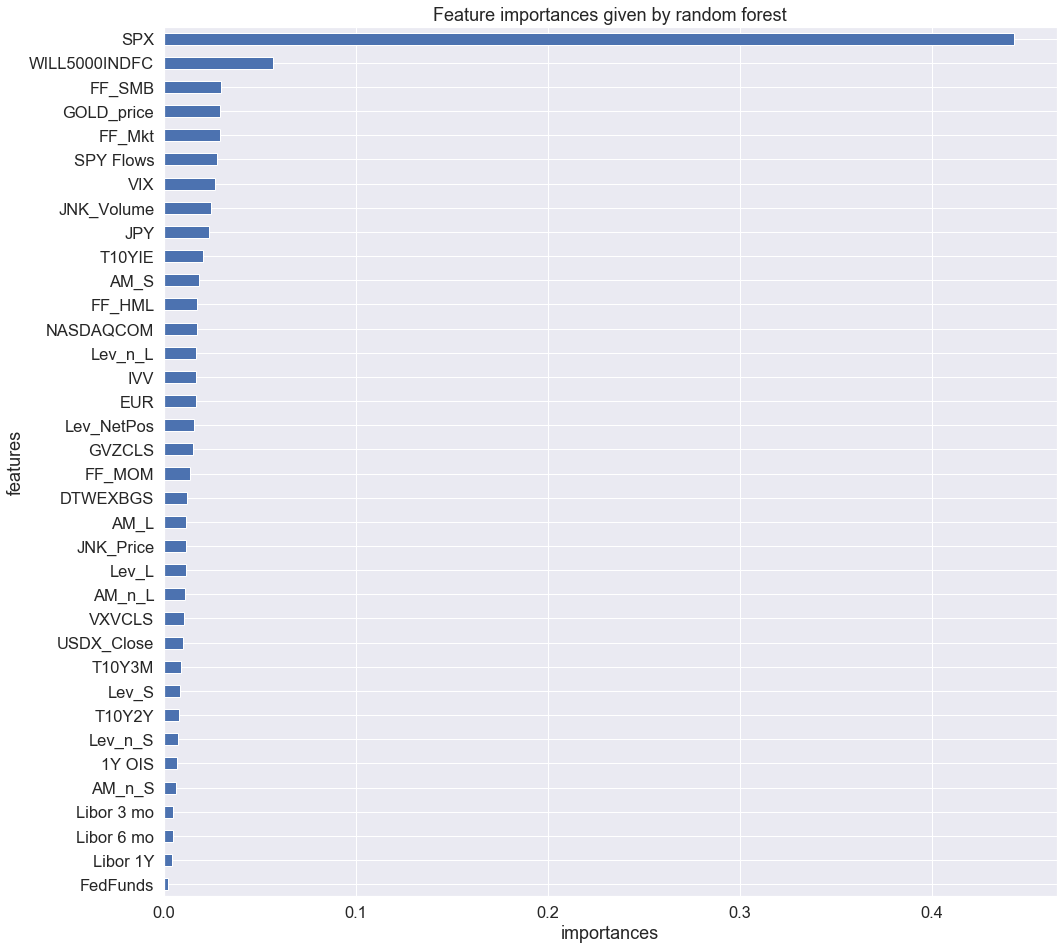

In [69]:
feat_importance = pd.Series(rf.feature_importances_, index = X_train.columns)
sns.set(font_scale = 1.5)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by random forest")
plt.show()

In [71]:
import pandas as pd
from sklearn import preprocessing

x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [72]:
df.columns = X_train.columns

In [73]:
from rfpimp import *
x = dropcol_importances(rf,df,y_train)
del x.index.name

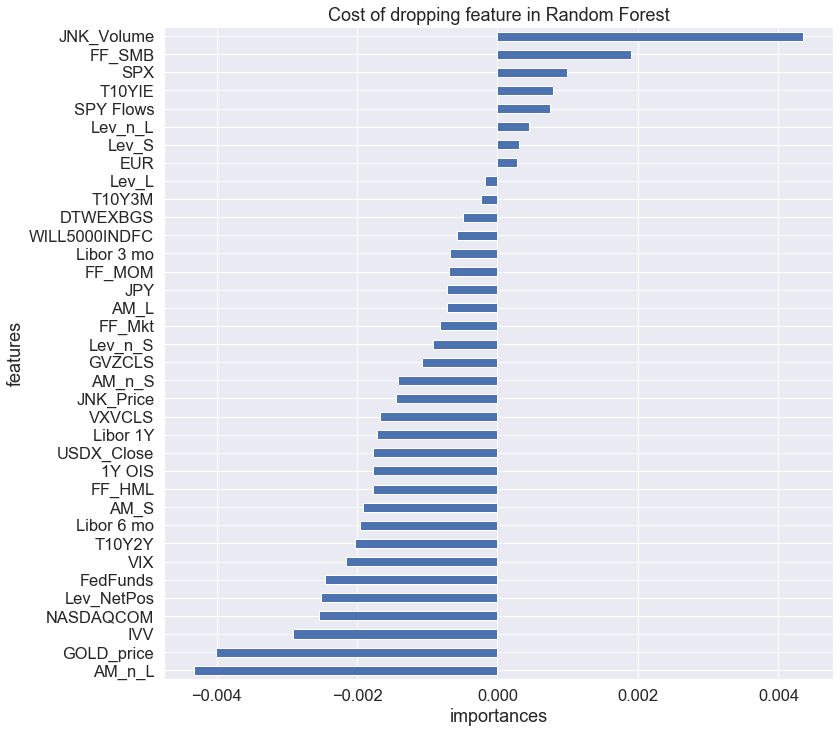

In [74]:

drop_cost = x.squeeze()
fis = np.argsort(drop_cost)
feat_importance = drop_cost[fis]
fig = plt.figure(figsize = [12,12])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Cost of dropping feature in Random Forest")
plt.show()

In [70]:
benchmark_res

,MSE,MAE
Random Forest,1.767e+08,9402.49


In [75]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve


In [77]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}).fit(X_train_std, y_train)

In [78]:
svr.best_params_

{'C': 1000.0, 'gamma': 0.01}

In [79]:
benchmark_res.loc['SVR', 'MSE'] = mean_squared_error(y_test, svr.predict(X_test_std))
benchmark_res.loc['SVR', 'MAE'] = mean_absolute_error(y_test, svr.predict(X_test_std))

In [80]:
benchmark_res

,MSE,MAE
Random Forest,1.767e+08,9402.49
SVR,2.21645e+08,10595.7


In [83]:
from sklearn.ensemble import GradientBoostingRegressor

p_test = {'learning_rate':[0.1,0.05,0.01,0.005],'min_samples_split':[20,50,80],'max_depth':[2,4,6,8],'n_estimators':[20,50,100]}

In [84]:
clf = GridSearchCV(GradientBoostingRegressor(), param_grid = p_test, cv = 5)
clf.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...ne,
                          

In [85]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 20,
 'n_estimators': 20}

In [87]:
params = {'n_estimators': 20, 'max_depth': 4, 'min_samples_split': 20,
          'learning_rate': 0.1}
clf = GradientBoostingRegressor(**params).fit(X_train, y_train)

In [88]:
benchmark_res.loc['Gradient Boosting', 'MSE'] = mean_squared_error(y_test, clf.predict(X_test_std))
benchmark_res.loc['Gradient Boosting', 'MAE'] = mean_absolute_error(y_test, clf.predict(X_test_std))

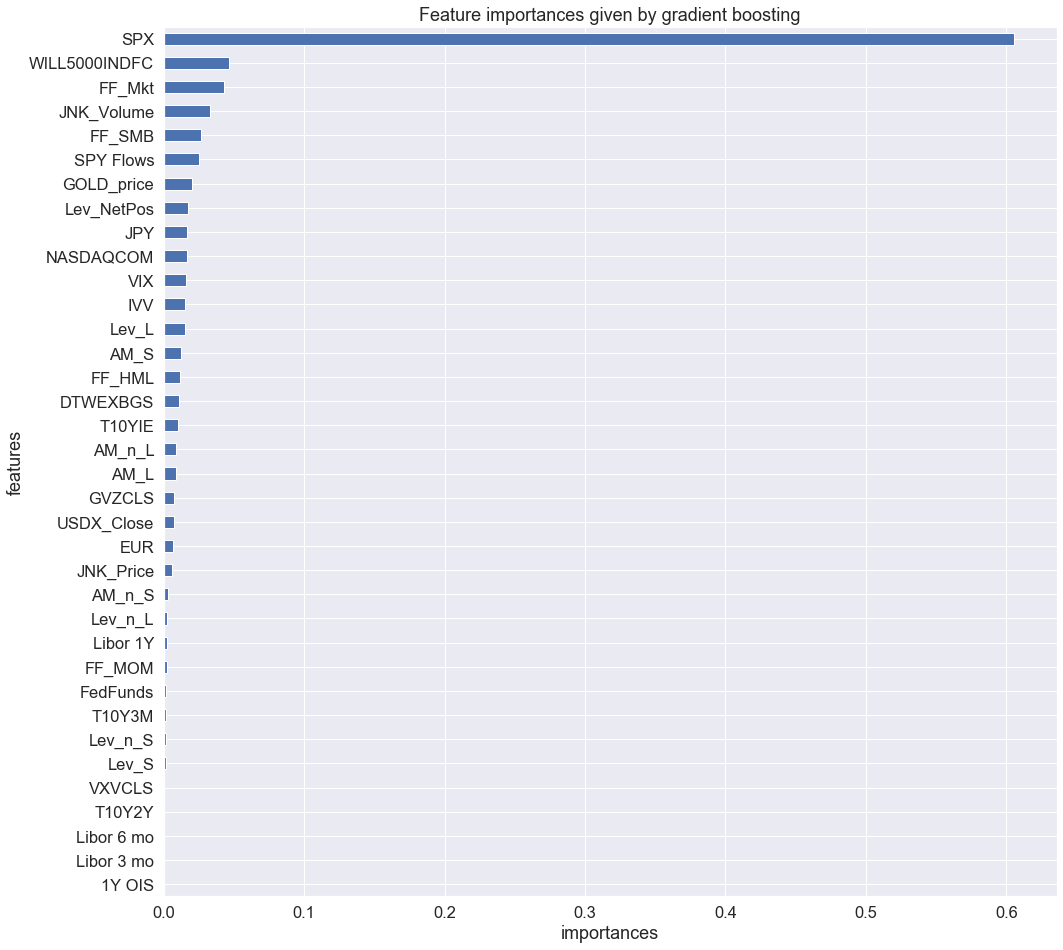

In [89]:
feat_importance = pd.Series(clf.feature_importances_, index = X_train.columns)
sns.set(font_scale = 1.5)
fis = np.argsort(feat_importance)
feat_importance = feat_importance[fis]
fig = plt.figure(figsize = [16,16])
ax = fig.subplots(1,1)
feat_importance.plot(kind = 'barh', ax = ax)
plt.ylabel('features')
plt.xlabel('importances')
plt.title("Feature importances given by gradient boosting")
plt.show()

In [90]:
benchmark_res

,MSE,MAE
Random Forest,1.767e+08,9402.49
SVR,2.21645e+08,10595.7
Gradient Boosting,2.64102e+08,12344.8
